# Food Delivery Dataset Analysis
## Combining Multiple Data Sources

This notebook demonstrates how to:
1. Load CSV data (orders.csv)
2. Load JSON data (users.json)
3. Load SQL data (restaurants.sql)
4. Merge datasets using left joins
5. Create visualizations and analysis

In [48]:
# Import required libraries
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Step 1: Load CSV Data (Orders)

In [49]:
# Load orders.csv
orders_df = pd.read_csv('orders.csv')
print(f"Orders loaded: {orders_df.shape}")

Orders loaded: (10000, 6)


## Step 2: Load JSON Data (Users)

In [50]:
# Load users.json
with open('users.json', 'r') as f:
    users_df = pd.DataFrame(json.load(f))
print(f"Users loaded: {users_df.shape}")

Users loaded: (3000, 4)


## Step 3: Load SQL Data (Restaurants)


In [51]:
# Parse SQL file to extract restaurant data
def parse_sql_file(sql_file_path):
    with open(sql_file_path, 'r') as f:
        content = f.read()
    insert_pattern = r"INSERT INTO restaurants VALUES\s*\((\d+),\s*'([^']+)',\s*'([^']+)',\s*([\d.]+)\);"
    matches = re.findall(insert_pattern, content)
    return pd.DataFrame([{
        'restaurant_id': int(m[0]),
        'restaurant_name': m[1],
        'cuisine': m[2],
        'rating': float(m[3])
    } for m in matches])

restaurants_df = parse_sql_file('restaurants.sql')
print(f"Restaurants loaded: {restaurants_df.shape}")

Restaurants loaded: (500, 4)


## Step 4: Data Preprocessing

In [52]:
# Convert order_date to datetime format
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], format='%d-%m-%Y')
print("Data preprocessing completed")

Data preprocessing completed


## Step 5: Merge the Data

In [53]:
# Merge orders with users (Left Join)
merged_df = pd.merge(orders_df, users_df, on='user_id', how='left')

# Merge with restaurants (Left Join)
final_df = pd.merge(merged_df, restaurants_df[['restaurant_id', 'cuisine', 'rating']],
                    on='restaurant_id', how='left')

print(f"Merged dataset: {final_df.shape}")

Merged dataset: (10000, 11)


## Step 6: Create Final Dataset

In [54]:
# Select and rename columns for final dataset
final_dataset = final_df[[
    'order_id', 'order_date', 'user_id', 'name', 'city', 'membership',
    'restaurant_id', 'restaurant_name', 'cuisine', 'rating', 'total_amount'
]].copy()

final_dataset.columns = [
    'order_id', 'order_date', 'user_id', 'user_name', 'city', 'membership',
    'restaurant_id', 'restaurant_name', 'cuisine', 'restaurant_rating', 'total_amount'
]

# Convert date to readable string format (DD-MM-YYYY) for Excel compatibility
final_dataset['order_date'] = final_dataset['order_date'].dt.strftime('%d-%m-%Y')

print(f"Final dataset: {final_dataset.shape}")

Final dataset: (10000, 11)


## Step 7: Save Final Dataset to CSV

In [55]:
# Save to CSV
final_dataset.to_csv('final_food_delivery_dataset.csv', index=False)
print(f"✅ Final dataset saved: final_food_delivery_dataset.csv ({len(final_dataset):,} records)")

✅ Final dataset saved: final_food_delivery_dataset.csv (10,000 records)


## Step 8: Exploratory Data Analysis

Now let's perform some initial analysis to understand the data better:

In [56]:
# Convert order_date back to datetime for analysis
final_dataset['order_date_dt'] = pd.to_datetime(final_dataset['order_date'], format='%d-%m-%Y')
final_dataset['month_year'] = final_dataset['order_date_dt'].dt.to_period('M')

# Order trends over time
orders_by_month = final_dataset.groupby('month_year').agg({
    'order_id': 'count',
    'total_amount': 'sum'
}).reset_index()
orders_by_month.columns = ['month', 'order_count', 'total_revenue']
print("Order Trends Over Time:")
print(orders_by_month)

Order Trends Over Time:
      month  order_count  total_revenue
0   2023-01          804      645818.76
1   2023-02          785      630867.40
2   2023-03          903      716738.98
3   2023-04          812      666097.18
4   2023-05          844      668428.61
5   2023-06          784      610822.93
6   2023-07          859      688559.45
7   2023-08          851      694987.58
8   2023-09          812      653838.07
9   2023-10          863      699187.73
10  2023-11          807      637772.43
11  2023-12          849      681303.50
12  2024-01           27       17201.50


In [57]:
# User behavior patterns
membership_stats = final_dataset.groupby('membership').agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean']
}).round(2)
membership_stats.columns = ['total_orders', 'total_revenue', 'avg_order_value']
print("\nMembership Statistics:")
print(membership_stats)


Membership Statistics:
            total_orders  total_revenue  avg_order_value
membership                                              
Gold                4987     3975364.89           797.15
Regular             5013     4036259.23           805.16


In [58]:
# City-wise and cuisine-wise performance
print("\n" + "=" * 60)
print("CITY-WISE AND CUISINE-WISE PERFORMANCE")
print("=" * 60)

# City-wise performance
city_performance = final_dataset.groupby('city').agg({
    'order_id': 'count',
    'total_amount': 'sum',
    'user_id': 'nunique'
}).round(2)
city_performance.columns = ['total_orders', 'total_revenue', 'unique_users']
city_performance = city_performance.sort_values('total_revenue', ascending=False)
print("\nCity-wise Performance:")
print(city_performance)

# Cuisine-wise performance
cuisine_performance = final_dataset.groupby('cuisine').agg({
    'order_id': 'count',
    'total_amount': 'sum',
    'restaurant_id': 'nunique'
}).round(2)
cuisine_performance.columns = ['total_orders', 'total_revenue', 'unique_restaurants']
cuisine_performance = cuisine_performance.sort_values('total_revenue', ascending=False)
print("\nCuisine-wise Performance:")
print(cuisine_performance)


CITY-WISE AND CUISINE-WISE PERFORMANCE

City-wise Performance:
           total_orders  total_revenue  unique_users
city                                                
Bangalore          2751     2206946.58           769
Chennai            2469     1990513.03           728
Pune               2430     1924797.93           704
Hyderabad          2350     1889366.58           682

Cuisine-wise Performance:
         total_orders  total_revenue  unique_restaurants
cuisine                                                 
Mexican          2581     2085503.09                 128
Italian          2532     2024203.80                 126
Indian           2469     1971412.58                 126
Chinese          2418     1930504.65                 120


In [59]:
# Membership impact analysis
print("\n" + "=" * 60)
print("MEMBERSHIP IMPACT ANALYSIS")
print("=" * 60)

membership_impact = final_dataset.groupby('membership').agg({
    'order_id': 'count',
    'total_amount': ['sum', 'mean', 'median'],
    'user_id': 'nunique'
}).round(2)
membership_impact.columns = ['total_orders', 'total_revenue', 'avg_order_value', 'median_order_value', 'unique_users']
membership_impact['orders_per_user'] = (membership_impact['total_orders'] / membership_impact['unique_users']).round(2)
print("\nMembership Impact:")
print(membership_impact)


MEMBERSHIP IMPACT ANALYSIS

Membership Impact:
            total_orders  total_revenue  avg_order_value  median_order_value  \
membership                                                                     
Gold                4987     3975364.89           797.15              802.10   
Regular             5013     4036259.23           805.16              812.56   

            unique_users  orders_per_user  
membership                                 
Gold                1430             3.49  
Regular             1453             3.45  


In [60]:
# Revenue distribution and seasonality
print("\n" + "=" * 60)
print("REVENUE DISTRIBUTION AND SEASONALITY")
print("=" * 60)

# Revenue by month
revenue_by_month = final_dataset.groupby('month_year').agg({
    'total_amount': ['sum', 'mean', 'count']
}).round(2)
revenue_by_month.columns = ['total_revenue', 'avg_order_value', 'order_count']
revenue_by_month = revenue_by_month.sort_index()
print("\nRevenue by Month:")
print(revenue_by_month)

# Overall statistics
print("\nOverall Revenue Statistics:")
print(f"Total Revenue: ₹{final_dataset['total_amount'].sum():,.2f}")
print(f"Average Order Value: ₹{final_dataset['total_amount'].mean():.2f}")
print(f"Median Order Value: ₹{final_dataset['total_amount'].median():.2f}")
print(f"Standard Deviation: ₹{final_dataset['total_amount'].std():.2f}")


REVENUE DISTRIBUTION AND SEASONALITY

Revenue by Month:
            total_revenue  avg_order_value  order_count
month_year                                             
2023-01         645818.76           803.26          804
2023-02         630867.40           803.65          785
2023-03         716738.98           793.73          903
2023-04         666097.18           820.32          812
2023-05         668428.61           791.98          844
2023-06         610822.93           779.11          784
2023-07         688559.45           801.58          859
2023-08         694987.58           816.67          851
2023-09         653838.07           805.22          812
2023-10         699187.73           810.18          863
2023-11         637772.43           790.30          807
2023-12         681303.50           802.48          849
2024-01          17201.50           637.09           27

Overall Revenue Statistics:
Total Revenue: ₹8,011,624.12
Average Order Value: ₹801.16
Median Order Val

## Step 9: Data Visualizations

Creating visualizations to better understand the data patterns:

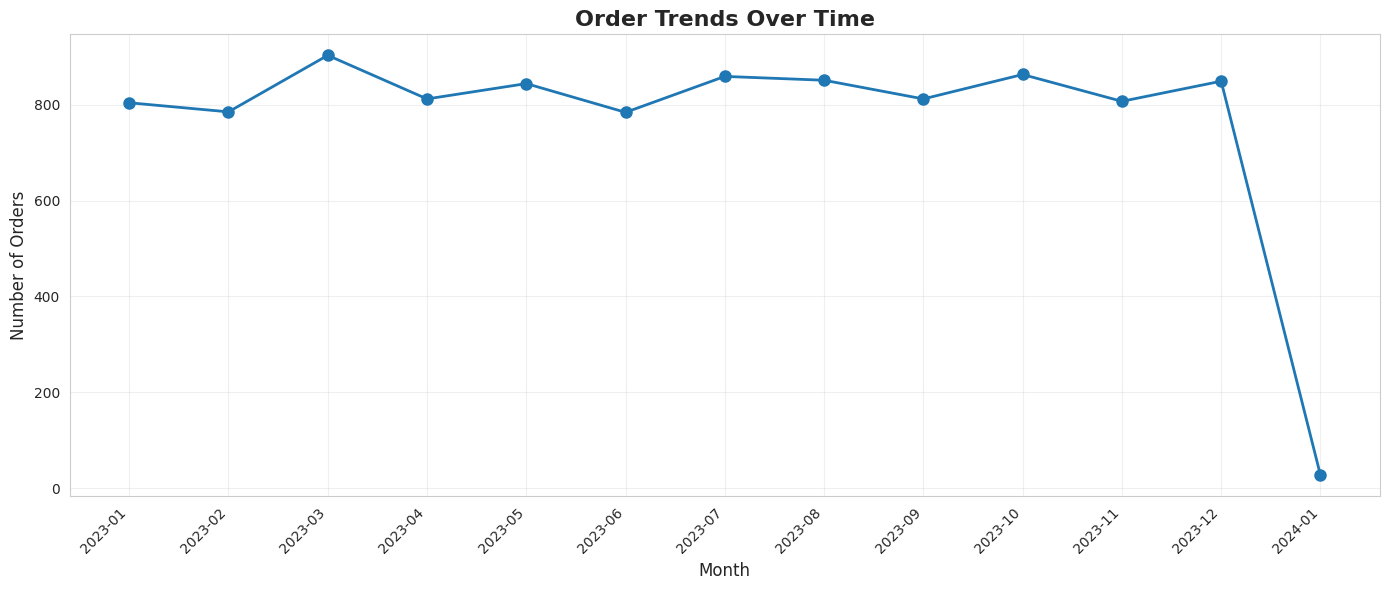

In [61]:
# Order Trends Over Time
plt.figure(figsize=(14, 6))
orders_by_month_plot = final_dataset.groupby('month_year')['order_id'].count()
orders_by_month_plot.index = orders_by_month_plot.index.astype(str)
plt.plot(orders_by_month_plot.index, orders_by_month_plot.values, marker='o', linewidth=2, markersize=8)
plt.title('Order Trends Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

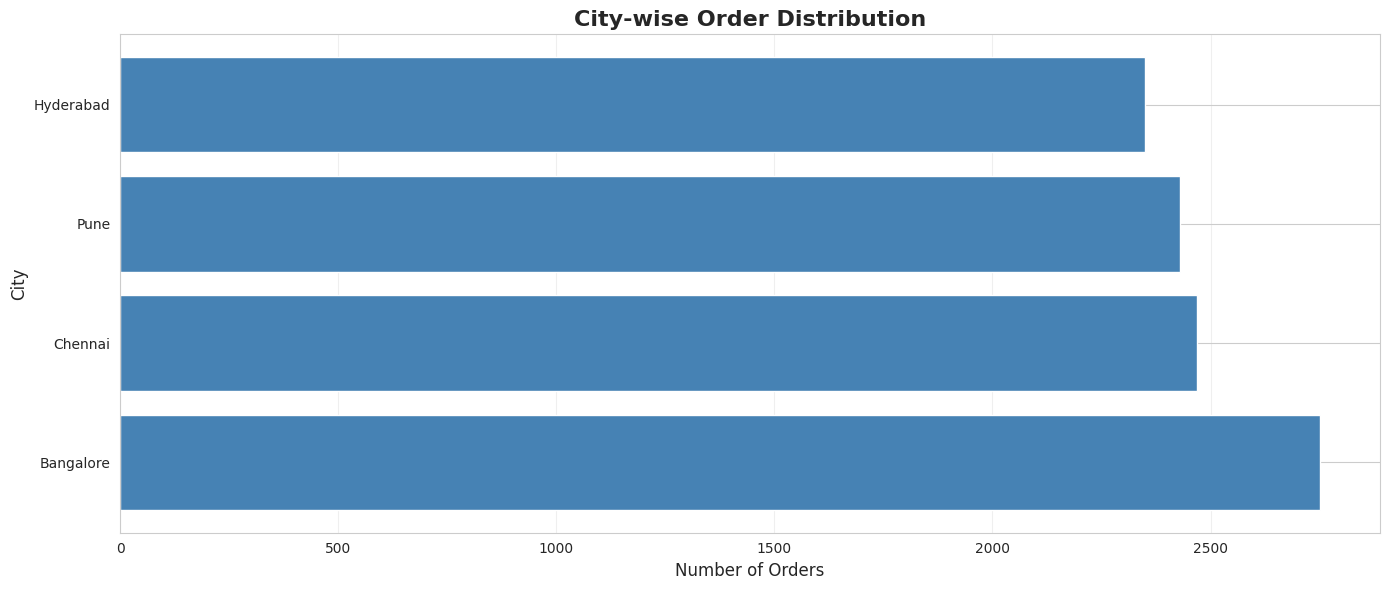

In [62]:
# City-wise Performance
plt.figure(figsize=(14, 6))
city_orders = final_dataset.groupby('city')['order_id'].count().sort_values(ascending=False)
plt.barh(city_orders.index, city_orders.values, color='steelblue')
plt.title('City-wise Order Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

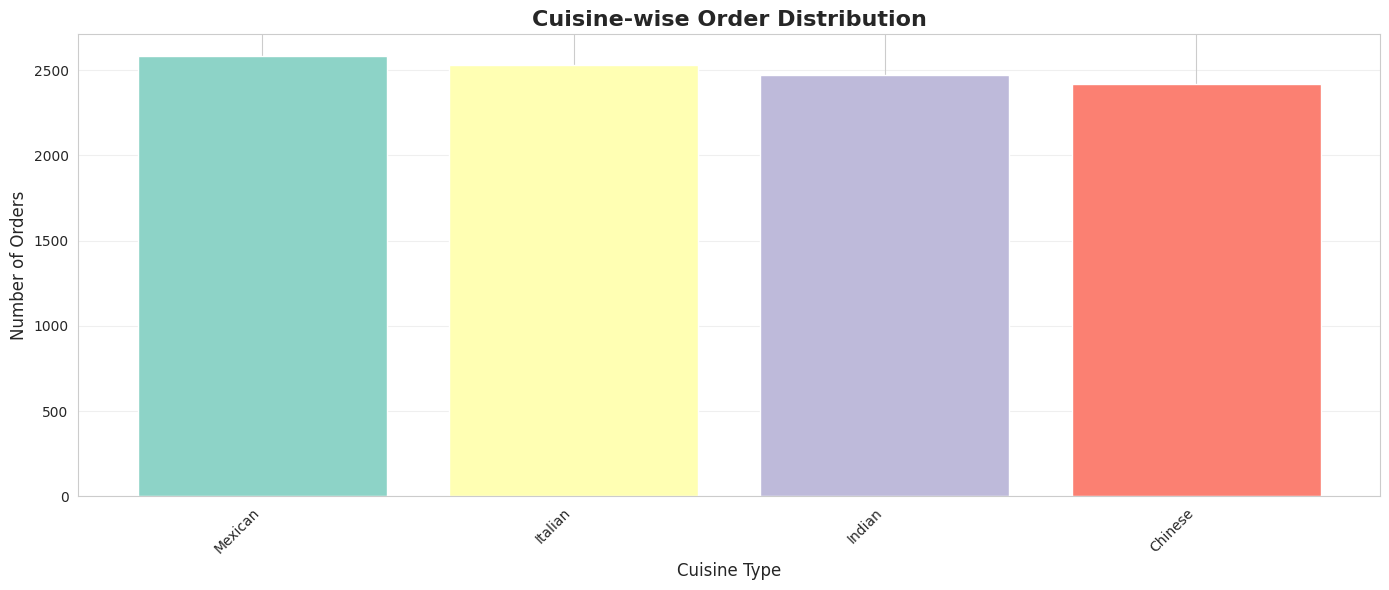

In [63]:
# Cuisine-wise Performance
plt.figure(figsize=(14, 6))
cuisine_orders = final_dataset.groupby('cuisine')['order_id'].count().sort_values(ascending=False)
colors = plt.cm.Set3(range(len(cuisine_orders)))
plt.bar(cuisine_orders.index, cuisine_orders.values, color=colors)
plt.title('Cuisine-wise Order Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Cuisine Type', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

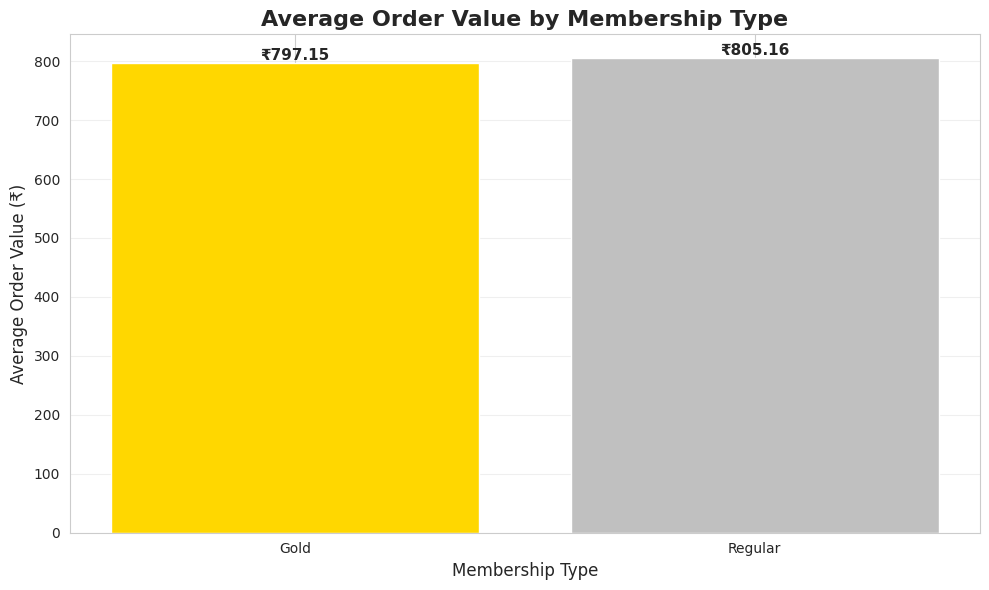

In [64]:
# Average Order Value by Membership
plt.figure(figsize=(10, 6))
avg_order_by_membership = final_dataset.groupby('membership')['total_amount'].mean()
plt.bar(avg_order_by_membership.index, avg_order_by_membership.values, color=['#FFD700', '#C0C0C0'])
plt.title('Average Order Value by Membership Type', fontsize=16, fontweight='bold')
plt.xlabel('Membership Type', fontsize=12)
plt.ylabel('Average Order Value (₹)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(avg_order_by_membership.values):
    plt.text(i, v, f'₹{v:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

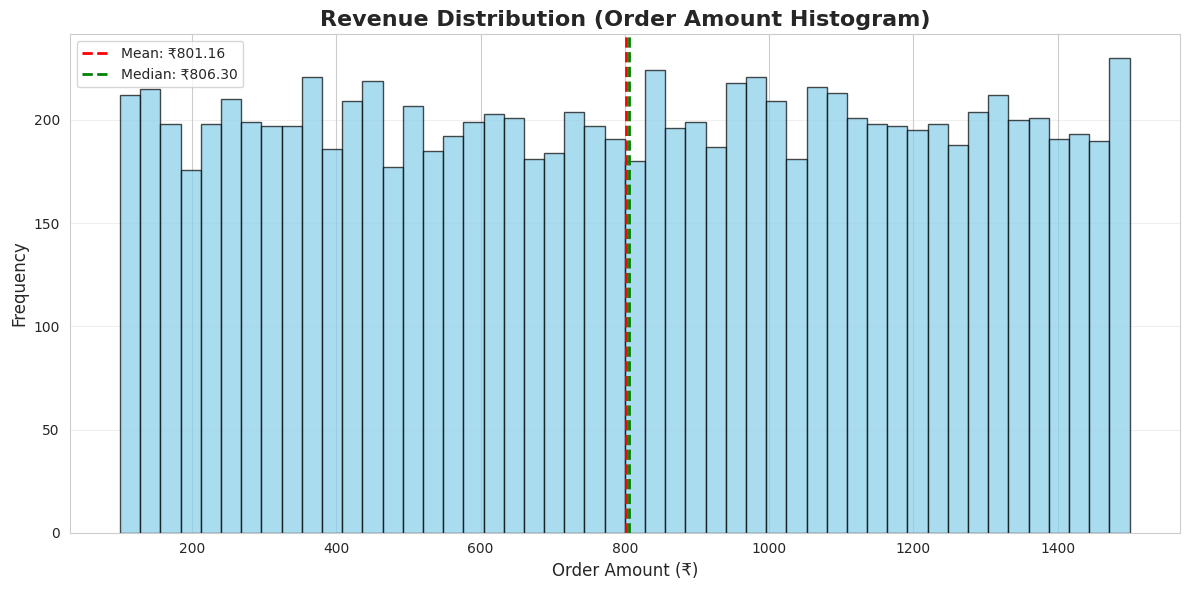

In [65]:
# Revenue Distribution Histogram
plt.figure(figsize=(12, 6))
plt.hist(final_dataset['total_amount'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Revenue Distribution (Order Amount Histogram)', fontsize=16, fontweight='bold')
plt.xlabel('Order Amount (₹)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(final_dataset['total_amount'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ₹{final_dataset["total_amount"].mean():.2f}')
plt.axvline(final_dataset['total_amount'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ₹{final_dataset["total_amount"].median():.2f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

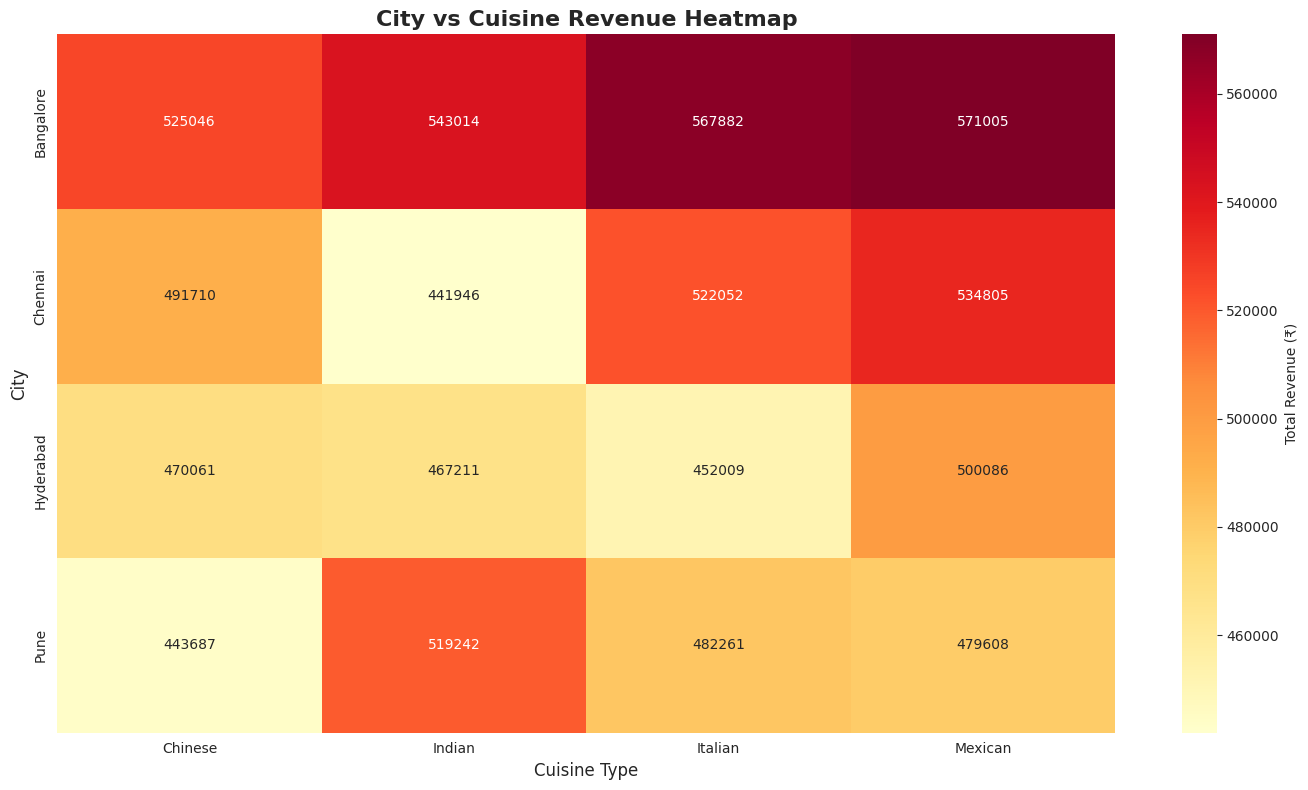

In [66]:
# Heatmap: City vs Cuisine Performance
plt.figure(figsize=(14, 8))
city_cuisine_pivot = final_dataset.pivot_table(
    values='total_amount',
    index='city',
    columns='cuisine',
    aggfunc='sum',
    fill_value=0
)
sns.heatmap(city_cuisine_pivot, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Total Revenue (₹)'})
plt.title('City vs Cuisine Revenue Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Cuisine Type', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()

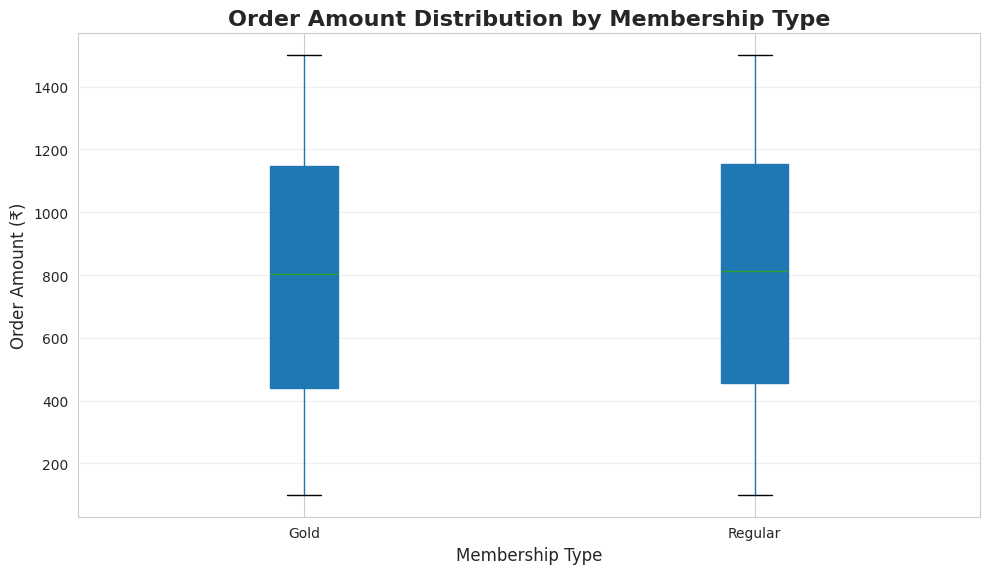

In [67]:
# Box Plot: Order Amount by Membership
plt.figure(figsize=(10, 6))
final_dataset.boxplot(column='total_amount', by='membership', ax=plt.gca(), patch_artist=True)
plt.title('Order Amount Distribution by Membership Type', fontsize=16, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.xlabel('Membership Type', fontsize=12)
plt.ylabel('Order Amount (₹)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Summary

### Key Insights from the Analysis:

1. **Order Trends**: The dataset shows order patterns over time, allowing analysis of seasonality and growth trends.

2. **User Behavior**:
   - Membership types (Gold vs Regular) show different ordering patterns
   - City-wise distribution reveals geographic preferences

3. **Restaurant Performance**:
   - Cuisine-wise analysis shows popular food types
   - Restaurant ratings can be correlated with order frequency

4. **Revenue Analysis**:
   - Total revenue distribution across different segments
   - Average order values by membership type
   - Seasonal revenue patterns

### Final Dataset Saved:
✅ **final_food_delivery_dataset.csv** - Contains all merged data ready for further analysis

In [68]:
# Final dataset summary
print("=" * 60)
print("FINAL DATASET SUMMARY")
print("=" * 60)
print(f"\nTotal Records: {len(final_dataset):,}")
print(f"Date Range: {final_dataset['order_date'].min()} to {final_dataset['order_date'].max()}")
print(f"Total Revenue: ₹{final_dataset['total_amount'].sum():,.2f}")
print(f"Average Order Value: ₹{final_dataset['total_amount'].mean():.2f}")
print(f"\nUnique Users: {final_dataset['user_id'].nunique():,}")
print(f"Unique Restaurants: {final_dataset['restaurant_id'].nunique():,}")
print(f"Unique Cities: {final_dataset['city'].nunique()}")
print(f"Unique Cuisines: {final_dataset['cuisine'].nunique()}")
print(f"\nMembership Distribution:")
print(final_dataset['membership'].value_counts())
print(f"\n✅ Dataset ready for analysis!")

FINAL DATASET SUMMARY

Total Records: 10,000
Date Range: 01-01-2023 to 31-12-2023
Total Revenue: ₹8,011,624.12
Average Order Value: ₹801.16

Unique Users: 2,883
Unique Restaurants: 500
Unique Cities: 4
Unique Cuisines: 4

Membership Distribution:
membership
Regular    5013
Gold       4987
Name: count, dtype: int64

✅ Dataset ready for analysis!
